##**Importing all the required library files**

In [18]:
import numpy as np
import scipy.signal as signal
import scipy.linalg as linalg
import math
from math import cos, sin, tan
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from matplotlib.patches import Circle, PathPatch
import mpl_toolkits.mplot3d.art3d as art3d
import random

##**Variable Definitions and Initializations**

In [19]:
# Variables
pn=10
pe=0
pd=1.8
phi=0
theta=0
psi=0
u=0
v=0.1
w=0
p=0
q=0
r=0

phi_c=0
theta_c=0
r_c=0

# Fixed Parameters
Ts = 1/10
Jx = 0.114700 
Jy = 0.057600
Jz = 0.171200
g = 9.806650
m = 1.56
#Simulation Parameters
Ts=0.05
Tfinal=30
Tsteps=Tfinal/Ts
##Tsteps=600
frames=int(Tsteps)
#Ship Variables
pn_s=0
pe_s=0
pd_s=0
psi_s=0

##**State Space Deifintion**

In [20]:
states=np.array([pn,pe,pd,u,v,w,phi,theta,psi,p,q,r])

##**List Initialization**

These lists will be used to store the time history of the states for the time of the simulation

In [21]:
##Quad History
pn_data=[]
pe_data=[]
pd_data=[]
phi_data=[]
theta_data=[]
psi_data=[]
u_data=[]
v_data=[]
w_data=[]
p_data=[]
q_data=[]
r_data=[]

##Ship States History
pn_s_data=[]
pe_s_data=[]
pd_s_data=[]
psi_s_data=[]

##Commanded States History
phi_c_data=[]
theta_c_data=[]
r_c_data=[]
pn_c_data=[]
pe_c_data=[]
pd_c_data=[]
u_c_data=[]
v_c_data=[]
w_c_data=[]
psi_c_data=[]

## Error States History
error_phi=[]
error_theta=[]
error_r=[]
error_pn=[]
error_pe=[]
error_pd=[]
error_u=[]
error_v=[]
error_w=[]
error_psi=[]

##Sensor Data History
p_sensor_data=[]
q_sensor_data=[]
r_sensor_data=[]
az_sensor_data=[]
pn_sensor_data=[]
pe_sensor_data=[]
pd_sensor_data=[]
phi_sensor_data=[]
theta_sensor_data=[]


##**Body To Inertial Frame** 

This function transforms the the desired vector to be transformed from the body frame to the inertial frame of reference.

In [22]:
def RM_body2inertial(phi, theta, psi):
    R_b_w=np.array([[cos(theta)*cos(psi), sin(phi)*sin(theta)*cos(psi)-cos(phi)*sin(psi), cos(phi)*sin(theta)*cos(psi)+sin(phi)*sin(psi)],
         [cos(theta)*sin(psi), sin(phi)*sin(theta)*sin(psi)+cos(phi)*cos(psi), cos(phi)*sin(theta)*sin(psi)-sin(phi)*cos(psi)],
         [-sin(theta), sin(phi)*cos(theta), cos(phi)*cos(theta)]])
    return R_b_w

##**Gyro to Body**

In [23]:
def rot_psi (psi):
    R_psi=np.array([[cos(psi), sin(psi), 0],
         [-sin(psi), cos(psi), 0],
         [0, 0, 1]])
    return R_psi

##**Axis Correction for Python**

Here in order to comply with the axix mode in python, we will rotate whatever we are constructing in python to NED frame (pn,pe,pd)

In [24]:
AC=np.array([[0,1,0],
      [1,0,0],
      [0,0,-1]])

##**Cube**

In [25]:
# vertices of a cube (defined in body frame)
w=1
v1=np.array([w/2,-w/2,-w/2]).T
v2=np.array([w/2, -w/2, w/2]).T
v3=np.array([w/2, w/2, w/2]).T
v4=np.array([w/2, w/2, -w/2]).T
v5=np.array([-w/2, -w/2, -w/2]).T
v6=np.array([-w/2, -w/2, w/2]).T
v7=np.array([-w/2, w/2, w/2]).T
v8=np.array([-w/2, w/2, -w/2]).T

v9=np.array([0, 0, -w/2]).T

v10=np.array([3*w/2, 0, -w/2]).T
v11=np.array([0, 3*w/2, -w/2]).T
v12=np.array([-3*w/2, 0, -w/2]).T
v13=np.array([0, -3*w/2, -w/2]).T

# Rotate and translate the vertices
pos_ned=np.array([pn, pe, pd]).T
R=RM_body2inertial(phi, theta, psi)
v1r=np.matmul(R,v1)+pos_ned
v2r=np.matmul(R,v2)+pos_ned
v3r=np.matmul(R,v3)+pos_ned
v4r=np.matmul(R,v4)+pos_ned
v5r=np.matmul(R,v5)+pos_ned
v6r=np.matmul(R,v6)+pos_ned
v7r=np.matmul(R,v7)+pos_ned
v8r=np.matmul(R,v8)+pos_ned

v9r=np.matmul(R,v9)+pos_ned

v10r=np.matmul(R,v10)+pos_ned
v11r=np.matmul(R,v11)+pos_ned
v12r=np.matmul(R,v12)+pos_ned
v13r=np.matmul(R,v13)+pos_ned

# Axis Correction

v1r=np.matmul(AC,v1r)
v2r=np.matmul(AC,v2r)
v3r=np.matmul(AC,v3r)
v4r=np.matmul(AC,v4r)
v5r=np.matmul(AC,v5r)
v6r=np.matmul(AC,v6r)
v7r=np.matmul(AC,v7r)
v8r=np.matmul(AC,v8r)

v9r=np.matmul(AC,v9r)

v10r=np.matmul(AC,v10r)
v11r=np.matmul(AC,v11r)
v12r=np.matmul(AC,v12r)
v13r=np.matmul(AC,v13r)

##**Cubefaces**

In [26]:
# face for 4 cube faces
f1_x=[v1r[0], v2r[0], v3r[0], v4r[0], v1r[0]]
f1_y=[v1r[1], v2r[1], v3r[1], v4r[1], v1r[1]]
f1_z=[v1r[2], v2r[2], v3r[2], v4r[2], v1r[2]]
f2_x=[v5r[0], v6r[0], v7r[0], v8r[0], v5r[0]]
f2_y=[v5r[1], v6r[1], v7r[1], v8r[1], v5r[1]]
f2_z=[v5r[2], v6r[2], v7r[2], v8r[2], v5r[2]]
f3_x=[v3r[0], v4r[0], v8r[0], v7r[0], v3r[0]]
f3_y=[v3r[1], v4r[1], v8r[1], v7r[1], v3r[1]]
f3_z=[v3r[2], v4r[2], v8r[2], v7r[2], v3r[2]]
f4_x=[v2r[0], v1r[0], v5r[0], v6r[0], v2r[0]]
f4_y=[v2r[1], v1r[1], v5r[1], v6r[1], v2r[1]]
f4_z=[v2r[2], v1r[2], v5r[2], v6r[2], v2r[2]]

##**Rotors for front n back**

In [27]:
# rotors for front, back, right,left
rf_x=[v9r[0],v10r[0]]
rf_y=[v9r[1],v10r[1]]
rf_z=[v9r[2],v10r[2]]
rb_x=[v9r[0],v12r[0]]
rb_y=[v9r[1],v12r[1]]
rb_z=[v9r[2],v12r[2]]
rl_x=[v9r[0],v11r[0]]
rl_y=[v9r[1],v11r[1]]
rl_z=[v9r[2],v11r[2]]
rr_x=[v9r[0],v13r[0]]
rr_y=[v9r[1],v13r[1]]
rr_z=[v9r[2],v13r[2]]

fan_x=[v10r[0], v11r[0], v12r[0], v13r[0]]
fan_y=[v10r[1], v11r[1], v12r[1], v13r[1]]
fan_z=[v10r[2], v11r[2], v12r[2], v13r[2]]

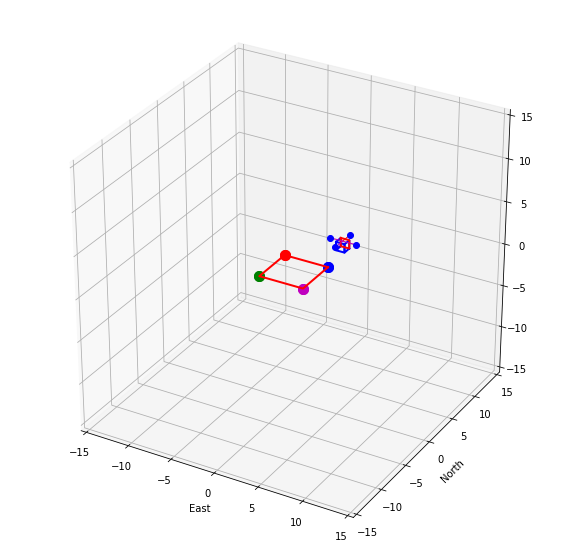

In [28]:
pn_data.append(states[0])
pe_data.append(states[1])
pd_data.append(states[2])
phi_data.append(states[6])
theta_data.append(states[7])
psi_data.append(states[8])
u_data.append(states[3])
v_data.append(states[4])
w_data.append(states[5])
p_data.append(states[9])
q_data.append(states[10])
r_data.append(states[11])

pn_c_data.append(0)
pe_c_data.append(0)
pd_c_data.append(0)

# coordinate frame
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.xlabel('East')
plt.ylabel('North')

ax.set_xlim(( -15, 15))            
ax.set_ylim((-15, 15))
ax.set_zlim((-15, 15))

face2, = ax.plot(f2_x, f2_y, f2_z, 'b', lw=2)
face3, = ax.plot(f3_x, f3_y, f3_z, 'b', lw=2)
face4, = ax.plot(f4_x, f4_y, f4_z, 'b', lw=2)
face1, = ax.plot(f1_x, f1_y, f1_z, 'r', lw=2)

rotorf, = ax.plot(rf_x, rf_y, rf_z, 'r', lw=1)
rotorb, = ax.plot(rb_x, rb_y, rb_z, 'm', lw=1)
rotorl, = ax.plot(rl_x, rl_y, rl_z, 'm', lw=1)
rotorr, = ax.plot(rr_x, rr_y, rr_z, 'm', lw=1)

fan,=ax.plot(fan_x,fan_y,fan_z,'bo',markersize=6)

quad_traj,=ax.plot(pe_data,pn_data,pd_data,'b:',lw=2)

ref_traj,=ax.plot(pe_c_data,pn_c_data,pd_c_data,'y:',lw=2)

# vertices of a Platform (defined in body frame)
W_s=5 #Platform W_s X W_s

# Rotate and translate the vertices
v1_s=np.array([W_s/2,W_s/2,0]).T
v2_s=np.array([W_s/2,-W_s/2,0]).T
v3_s=np.array([-W_s/2,-W_s/2,0]).T
v4_s=np.array([-W_s/2,W_s/2,0]).T
v5_s=np.array([0,0,0]).T

pos_ned_s=np.array([pn_s, pe_s, pd_s]).T

v1r_s=v1_s+pos_ned_s
v2r_s=v2_s+pos_ned_s
v3r_s=v3_s+pos_ned_s
v4r_s=v4_s+pos_ned_s
v5r_s=v5_s+pos_ned_s

# Axis Correction
v1r_s=np.matmul(AC,v1r_s)
v2r_s=np.matmul(AC,v2r_s)
v3r_s=np.matmul(AC,v3r_s)
v4r_s=np.matmul(AC,v4r_s)
v5r_s=np.matmul(AC,v5r_s)

# face for 4 sides of platform
f1_x_s=[v1r_s[0], v2r_s[0], v3r_s[0], v4r_s[0], v1r_s[0]]
f1_y_s=[v1r_s[1], v2r_s[1], v3r_s[1], v4r_s[1], v1r_s[1]]
f1_z_s=[v1r_s[2], v2r_s[2], v3r_s[2], v4r_s[2], v1r_s[2]]

L1_x=[v1r_s[0],v1r_s[0]]
L1_y=[v1r_s[1],v1r_s[1]]
L1_z=[v1r_s[2],v1r_s[2]]
L2_x=[v2r_s[0],v2r_s[0]]
L2_y=[v2r_s[1],v2r_s[1]]
L2_z=[v2r_s[2],v2r_s[2]]
L3_x=[v3r_s[0],v3r_s[0]]
L3_y=[v3r_s[1],v3r_s[1]]
L3_z=[v3r_s[2],v3r_s[2]]
L4_x=[v4r_s[0],v4r_s[0]]
L4_y=[v4r_s[1],v4r_s[1]]
L4_z=[v4r_s[2],v4r_s[2]]
L5_x=[v5r_s[0],v5r_s[0]]
L5_y=[v5r_s[1],v5r_s[1]]
L5_z=[v5r_s[2],v5r_s[2]]

L1,=ax.plot(L1_x, L1_y, L1_z, 'b-o',markersize=10)
L2,=ax.plot(L2_x, L2_y, L2_z, 'r-o',markersize=10)
L3,=ax.plot(L3_x, L3_y, L3_z, 'g-o',markersize=10)
L4,=ax.plot(L4_x, L4_y, L4_z, 'm-o',markersize=10)

ship, = ax.plot(f1_x_s, f1_y_s, f1_z_s, 'r', lw=2)

##**Definition of Motion of the Ship**

In [29]:
#Trajectory for Ship
R_s=10 #Radius of ship trajectory
W_ss=0.01/3  #Angular Velocity of Ship

pn_s_mes=[]
pe_s_mes=[]
pd_s_mes=[]
psi_s_mes=[]

def ship_trajectory(j):
  pn_s_mes=R_s*cos(j*W_ss)
  pe_s_mes=R_s*sin(j*W_ss)
  pd_s_mes=-1.86
  psi_s_mes=1
  return(pn_s_mes,pe_s_mes,pd_s_mes,psi_s_mes)

##**Function to handle the plot of the quadrotor as states change**

In [30]:
def quadrotor(phi, theta, psi , pn, pe, pd):
  v1=np.array([w/2,-w/2,-w/2]).T
  v2=np.array([w/2, -w/2, w/2]).T
  v3=np.array([w/2, w/2, w/2]).T
  v4=np.array([w/2, w/2, -w/2]).T
  v5=np.array([-w/2, -w/2, -w/2]).T
  v6=np.array([-w/2, -w/2, w/2]).T
  v7=np.array([-w/2, w/2, w/2]).T
  v8=np.array([-w/2, w/2, -w/2]).T
  v9=np.array([0, 0, -w/2]).T
  v10=np.array([3*w/2, 0, -w/2]).T
  v11=np.array([0, 3*w/2, -w/2]).T
  v12=np.array([-3*w/2, 0, -w/2]).T
  v13=np.array([0, -3*w/2, -w/2]).T

  pos_ned=np.array([pn, pe, pd]).T
  
  R=RM_body2inertial(phi, theta, psi)

  v1r=np.matmul(R,v1)+pos_ned
  v2r=np.matmul(R,v2)+pos_ned
  v3r=np.matmul(R,v3)+pos_ned
  v4r=np.matmul(R,v4)+pos_ned
  v5r=np.matmul(R,v5)+pos_ned
  v6r=np.matmul(R,v6)+pos_ned
  v7r=np.matmul(R,v7)+pos_ned
  v8r=np.matmul(R,v8)+pos_ned
  v9r=np.matmul(R,v9)+pos_ned
  v10r=np.matmul(R,v10)+pos_ned
  v11r=np.matmul(R,v11)+pos_ned
  v12r=np.matmul(R,v12)+pos_ned
  v13r=np.matmul(R,v13)+pos_ned

  v1r=np.matmul(AC,v1r)
  v2r=np.matmul(AC,v2r)
  v3r=np.matmul(AC,v3r)
  v4r=np.matmul(AC,v4r)
  v5r=np.matmul(AC,v5r)
  v6r=np.matmul(AC,v6r)
  v7r=np.matmul(AC,v7r)
  v8r=np.matmul(AC,v8r)

  v9r=np.matmul(AC,v9r)

  v10r=np.matmul(AC,v10r)
  v11r=np.matmul(AC,v11r)
  v12r=np.matmul(AC,v12r)
  v13r=np.matmul(AC,v13r)

  f1_x=[v1r[0], v2r[0], v3r[0], v4r[0], v1r[0]]
  f1_y=[v1r[1], v2r[1], v3r[1], v4r[1], v1r[1]]
  f1_z=[v1r[2], v2r[2], v3r[2], v4r[2], v1r[2]]
  f2_x=[v5r[0], v6r[0], v7r[0], v8r[0], v5r[0]]
  f2_y=[v5r[1], v6r[1], v7r[1], v8r[1], v5r[1]]
  f2_z=[v5r[2], v6r[2], v7r[2], v8r[2], v5r[2]]
  f3_x=[v3r[0], v4r[0], v8r[0], v7r[0], v3r[0]]
  f3_y=[v3r[1], v4r[1], v8r[1], v7r[1], v3r[1]]
  f3_z=[v3r[2], v4r[2], v8r[2], v7r[2], v3r[2]]
  f4_x=[v2r[0], v1r[0], v5r[0], v6r[0], v2r[0]]
  f4_y=[v2r[1], v1r[1], v5r[1], v6r[1], v2r[1]]
  f4_z=[v2r[2], v1r[2], v5r[2], v6r[2], v2r[2]]

  rf_x=[v9r[0],v10r[0]]
  rf_y=[v9r[1],v10r[1]]
  rf_z=[v9r[2],v10r[2]]
  rb_x=[v9r[0],v12r[0]]
  rb_y=[v9r[1],v12r[1]]
  rb_z=[v9r[2],v12r[2]]
  rl_x=[v9r[0],v11r[0]]
  rl_y=[v9r[1],v11r[1]]
  rl_z=[v9r[2],v11r[2]]
  rr_x=[v9r[0],v13r[0]]
  rr_y=[v9r[1],v13r[1]]
  rr_z=[v9r[2],v13r[2]]

  fan_x=[v10r[0], v11r[0], v12r[0], v13r[0]]
  fan_y=[v10r[1], v11r[1], v12r[1], v13r[1]]
  fan_z=[v10r[2], v11r[2], v12r[2], v13r[2]]

  face1.set_data(f1_x, f1_y)
  face1.set_3d_properties(f1_z)

  face2.set_data(f2_x, f2_y)
  face2.set_3d_properties(f2_z)

  face3.set_data(f3_x, f3_y)
  face3.set_3d_properties(f3_z)

  face4.set_data(f4_x, f4_y)
  face4.set_3d_properties(f4_z)

  rotorf.set_data(rf_x, rf_y)
  rotorf.set_3d_properties(rf_z)

  rotorb.set_data(rb_x, rb_y)
  rotorb.set_3d_properties(rb_z)

  rotorl.set_data(rl_x, rl_y)
  rotorl.set_3d_properties(rl_z)

  rotorr.set_data(rr_x, rr_y)
  rotorr.set_3d_properties(rr_z)

  fan.set_data(fan_x,fan_y)
  fan.set_3d_properties(fan_z)

  return (face1,face2,face3,face4,rotorf,rotorb,rotorl,rotorr)

##**Quad Fans xyz values**

In [31]:
def quad_fan_sens(phi, theta, psi , pn, pe, pd):
  v10=np.array([3*w/2, 0, -w/2]).T
  v11=np.array([0, 3*w/2, -w/2]).T
  v12=np.array([-3*w/2, 0, -w/2]).T
  v13=np.array([0, -3*w/2, -w/2]).T

  N_i=np.array([1, 0, 0]).T
  E_i=np.array([0, 1, 0]).T
  D_i=np.array([0, 0, 1]).T

  pos_ned=np.array([pn, pe, pd]).T
  R=RM_body2inertial(phi, theta, psi)

  v10r=np.matmul(R,v10)+pos_ned
  v11r=np.matmul(R,v11)+pos_ned
  v12r=np.matmul(R,v12)+pos_ned
  v13r=np.matmul(R,v13)+pos_ned

  v10r=np.matmul(AC,v10r)
  v11r=np.matmul(AC,v11r)
  v12r=np.matmul(AC,v12r)
  v13r=np.matmul(AC,v13r)

  fan1sens=[v10r[0], v10r[1], v10r[2]]
  fan2sens=[v11r[0], v11r[1], v11r[2]]
  fan3sens=[v12r[0], v12r[1], v12r[2]]
  fan4sens=[v13r[0], v13r[1], v13r[2]]

  return (fan1sens,fan2sens,fan3sens,fan4sens)

##**Function to handle the plot of the ship as states change**

In [32]:
def draw_ship(pn_s,pe_s,pd_s,psi_s):

  #pn_s,pe_s,pd_s,psi_s=ship_trajectory(i)

  AC=np.array([[0,1,0],
              [1,0,0],
              [0,0,-1]])

  # vertices of a Platform (defined in body frame)
  W_s=5 #Platform W_s X W_s

  # Rotate and translate the vertices
  v1_s=np.array([W_s/2,W_s/2,0]).T
  v2_s=np.array([W_s/2,-W_s/2,0]).T
  v3_s=np.array([-W_s/2,-W_s/2,0]).T
  v4_s=np.array([-W_s/2,W_s/2,0]).T
  v5_s=np.array([0,0,0]).T

  pos_ned_s=np.array([float(pn_s), float(pe_s), float(pd_s)]).T

  v1r_s=v1_s+pos_ned_s
  v2r_s=v2_s+pos_ned_s
  v3r_s=v3_s+pos_ned_s
  v4r_s=v4_s+pos_ned_s
  v5r_s=v5_s+pos_ned_s

  # Axis Correction
  v1r_s=np.matmul(AC,v1r_s)
  v2r_s=np.matmul(AC,v2r_s)
  v3r_s=np.matmul(AC,v3r_s)
  v4r_s=np.matmul(AC,v4r_s)
  v5r_s=np.matmul(AC,v5r_s)

  # face for 4 sides of platform
  f1_x_s=[v1r_s[0], v2r_s[0], v3r_s[0], v4r_s[0], v1r_s[0]]
  f1_y_s=[v1r_s[1], v2r_s[1], v3r_s[1], v4r_s[1], v1r_s[1]]
  f1_z_s=[v1r_s[2], v2r_s[2], v3r_s[2], v4r_s[2], v1r_s[2]]

  ship.set_data(f1_x_s, f1_y_s)
  ship.set_3d_properties(f1_z_s)

  L1_x=[v1r_s[0],v1r_s[0]]
  L1_y=[v1r_s[1],v1r_s[1]]
  L1_z=[v1r_s[2],v1r_s[2]]
  L2_x=[v2r_s[0],v2r_s[0]]
  L2_y=[v2r_s[1],v2r_s[1]]
  L2_z=[v2r_s[2],v2r_s[2]]
  L3_x=[v3r_s[0],v3r_s[0]]
  L3_y=[v3r_s[1],v3r_s[1]]
  L3_z=[v3r_s[2],v3r_s[2]]
  L4_x=[v4r_s[0],v4r_s[0]]
  L4_y=[v4r_s[1],v4r_s[1]]
  L4_z=[v4r_s[2],v4r_s[2]]
  L5_x=[v5r_s[0],v5r_s[0]]
  L5_y=[v5r_s[1],v5r_s[1]]
  L5_z=[v5r_s[2],v5r_s[2]]

  L1.set_data(L1_x,L1_y)
  L1.set_3d_properties(L1_z)

  L2.set_data(L2_x,L2_y)
  L2.set_3d_properties(L2_z)

  L3.set_data(L3_x,L3_y)
  L3.set_3d_properties(L3_z)

  L4.set_data(L4_x,L4_y)
  L4.set_3d_properties(L4_z)

  #L5.set_data(L5_x,L5_y)
  #L5.set_3d_properties(L5_z)

  L1cord=[v1r_s[0],v1r_s[1],v1r_s[2]]
  L2cord=[v2r_s[0],v2r_s[1],v2r_s[2]]
  L3cord=[v3r_s[0],v3r_s[1],v3r_s[2]]
  L4cord=[v4r_s[0],v4r_s[1],v4r_s[2]]
  L5cord=[v5r_s[0],v5r_s[1],v5r_s[2]]

  # print('pn_s,pe_s,pd_s,psi_s = ',pn_s,pe_s,pd_s)

  return(ship,L1,L2,L3,L4)

##**Ship Sensor Values**

In [33]:
def ship_sens_val(i):

  pn_s,pe_s,pd_s,psi_s=ship_trajectory(i)

  AC=np.array([[0,1,0],
              [1,0,0],
              [0,0,-1]])

  # vertices of a Platform (defined in body frame)
  W_s=5 #Platform W_s X W_s

  # Rotate and translate the vertices
  v1_s=np.array([W_s/2,W_s/2,0]).T
  v2_s=np.array([W_s/2,-W_s/2,0]).T
  v3_s=np.array([-W_s/2,-W_s/2,0]).T
  v4_s=np.array([-W_s/2,W_s/2,0]).T
  v5_s=np.array([0,0,0]).T

  pos_ned_s=np.array([pn_s, pe_s, pd_s]).T

  v1r_s=v1_s+pos_ned_s
  v2r_s=v2_s+pos_ned_s
  v3r_s=v3_s+pos_ned_s
  v4r_s=v4_s+pos_ned_s
  v5r_s=v5_s+pos_ned_s

  # Axis Correction
  v1r_s=np.matmul(AC,v1r_s)
  v2r_s=np.matmul(AC,v2r_s)
  v3r_s=np.matmul(AC,v3r_s)
  v4r_s=np.matmul(AC,v4r_s)
  v5r_s=np.matmul(AC,v5r_s)

  # face for 4 sides of platform
  f1_x_s=[v1r_s[0], v2r_s[0], v3r_s[0], v4r_s[0], v1r_s[0]]
  f1_y_s=[v1r_s[1], v2r_s[1], v3r_s[1], v4r_s[1], v1r_s[1]]
  f1_z_s=[v1r_s[2], v2r_s[2], v3r_s[2], v4r_s[2], v1r_s[2]]


  L1_x=[v1r_s[0],v1r_s[0]]
  L1_y=[v1r_s[1],v1r_s[1]]
  L1_z=[v1r_s[2],v1r_s[2]]
  L2_x=[v2r_s[0],v2r_s[0]]
  L2_y=[v2r_s[1],v2r_s[1]]
  L2_z=[v2r_s[2],v2r_s[2]]
  L3_x=[v3r_s[0],v3r_s[0]]
  L3_y=[v3r_s[1],v3r_s[1]]
  L3_z=[v3r_s[2],v3r_s[2]]
  L4_x=[v4r_s[0],v4r_s[0]]
  L4_y=[v4r_s[1],v4r_s[1]]
  L4_z=[v4r_s[2],v4r_s[2]]
  L5_x=[v5r_s[0],v5r_s[0]]
  L5_y=[v5r_s[1],v5r_s[1]]
  L5_z=[v5r_s[2],v5r_s[2]]

  L1cord=[v1r_s[0],v1r_s[1],v1r_s[2]]
  L2cord=[v2r_s[0],v2r_s[1],v2r_s[2]]
  L3cord=[v3r_s[0],v3r_s[1],v3r_s[2]]
  L4cord=[v4r_s[0],v4r_s[1],v4r_s[2]]
  L5cord=[v5r_s[0],v5r_s[1],v5r_s[2]]

  return(L1cord,L2cord,L3cord,L4cord,L5cord)

##**LQR Controller to Stabilize the Attitude**

This controller will solely be used to get the attitude values namely phi, theta, psi to their commanded values phi_c, theta_c and psi_c. This controller is used to change the attitude to the commanded values as closely as possible for the quadrotor to follow a desired trajectory which is provided through differential flatness.

In [34]:
#Attitude_Control_LQR
def attitude_LQR():
  A=np.array([[0, 1, 0, 0, 0 ],
              [0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0]])
  
  B=np.array([[0, 0, 0],
              [1/Jx, 0, 0],
              [0, 0, 0],
              [0, 1/Jy, 0],
              [0, 0, 1/Jz]])

  Q=np.array([[10, 0, 0, 0, 0],
              [0, 0.1, 0, 0, 0],
              [0, 0, 10, 0, 0],
              [0, 0, 0, 0.1, 0],
              [0, 0, 0, 0, 1]])
  
  R=np.array([[0.1, 0, 0], 
              [0, 0.1, 0],
              [0, 0, 0.1]])

  P=np.matrix(linalg.solve_continuous_are(A, B, Q, R))
  K=np.matrix(linalg.inv(R)*(B.T*P))
  eigVals, eigVecs = linalg.eig(A-B*K)

  return K

  #Calling_Attitude_Control_LQR
def controller_LQR_roll(y, K):
  Tphi=-K[0,0]*y[0]-K[0,1]*y[1]-K[0,2]*y[2]-K[0,3]*y[3]-K[0,4]*y[4]    
  return Tphi

def controller_LQR_pitch(y, K):
  Ttheta=-K[1,0]*y[0]-K[1,1]*y[1]-K[1,2]*y[2]-K[1,3]*y[3]-K[1,4]*y[4]   
  return Ttheta

def controller_LQR_yaw(y, K):
  Tpsi=-K[2,0]*y[0]-K[2,1]*y[1]-K[2,2]*y[2]-K[2,3]*y[3]-K[2,4]*y[4]    
  return Tpsi

##**LQR Controller to Generate the Trajectory**

This controller basically gives us the required gain K using which we can generated the commanded Force, the commanded phi, theta and psi

In [35]:
#Trajectory_Control_LQR
def trajectory_LQR ():
  A=np.array([[0, 0, 0, 1, 0, 0, 0 ], 
              [0, 0, 0, 0, 1, 0, 0 ], 
              [0, 0, 0, 0, 0, 1, 0 ], 
              [0, 0, 0, 0, 0, 0, 0 ], 
              [0, 0, 0, 0, 0, 0, 0 ], 
              [0, 0, 0, 0, 0, 0, 0 ], 
              [0, 0, 0, 0, 0, 0, 0 ]])
  
  B=np.array([[0, 0, 0, 0], 
              [0, 0, 0, 0], 
              [0, 0, 0, 0], 
              [1, 0, 0, 0], 
              [0, 1, 0, 0], 
              [0, 0, 1, 0], 
              [0, 0, 0, 1]])

  q1=0.03
  q2=0.03
  q3=0.03
  q4=0.06
  q5=0.06
  q6=0.06
  q7=1

  Q=np.array([[1/q1**2, 0, 0, 0, 0, 0, 0],
              [0, 1/q2**2, 0, 0, 0, 0, 0],
              [0, 0, 1/q3**2, 0, 0, 0, 0], 
              [0, 0, 0, 1/q4**2, 0, 0, 0],
              [0, 0, 0, 0, 1/q5**2, 0, 0], 
              [0, 0, 0, 0, 0, 1/q6**2, 0], 
              [0, 0, 0, 0, 0, 0, 1/q7**2]])
  
  r1=0.02
  r2=np.sqrt(0.1)
  R=np.array([[1/r1**2, 0, 0, 0],
              [0, 1/r1**2, 0, 0],
              [0, 0, 1/r2**2, 0],
              [0, 0, 0, 1/r2**2]])

  P=np.matrix(linalg.solve_continuous_are(A, B, Q, R))
  K=np.matrix(linalg.inv(R)*(B.T*P))
  eigVals, eigVecs = linalg.eig(A-B*K)
  return K



##**Inverse Mapping**

Function to generate the required F, phi_c, theta_c, psi_c

In [36]:
#Inverse maping
def trajectory_control_EKF(xhat,pn_s,pe_s,pd_s,psi_s,K):
  [pn_hat] =xhat[0]
  [pe_hat] =xhat[1]
  [pd_hat] =xhat[2]
  [u_hat]  =xhat[3]
  [v_hat]  =xhat[4]
  [w_hat]  =xhat[5]
  [psi_hat]=xhat[6]

  x=np.array([[pn_hat-pn_s], [pe_hat-pe_s], [pd_hat-pd_s], [u_hat], [v_hat], [w_hat], [psi_hat-psi_s]])
  uc=-np.matmul(K,x)

  up=np.array([uc[0,0], uc[1,0], uc[2,0]+g])

  F=m*np.sqrt(np.matmul(up.transpose(), up)) 

  R_psi=rot_psi(psi)
  z=-np.matmul(R_psi, up)*m/F

  phi_c=np.arcsin(-z[1])
  theta_c=np.arctan2(z[0], z[2]) 
  r_c=uc[3,0]*cos(phi)*cos(theta)-q*sin(phi)

  return [F, float(phi_c), float(theta_c), float(r_c)]

##**Quadrotor Dynamics**

This function basically solves for the state space derivative for each time step of the simulation, the mathematical formulations in the function are taken straight from Randal Beards Quadrotor notes.

In [37]:
def Dynamics( t, y, F, Tphi, Ttheta, Tpsi):
  pn=y[0]
  pe=y[1]
  pd=y[2]
  u=y[3]
  v=y[4]
  w=y[5]
  phi=y[6]
  theta=y[7]
  psi=y[8]
  p=y[9]
  q=y[10]
  r=y[11]

  R_b_w=RM_body2inertial(phi,theta,psi)
  ThrustVecBody=np.array([0, 0, -F/m]).T
  gravity_vec=np.array([0, 0, g]).T
  Acci=R_b_w@ThrustVecBody+gravity_vec

  Angv=np.matmul(np.array([[1,np.sin(phi)*np.tan(theta),np.cos(phi)*np.tan(theta)],[0,np.cos(phi),-np.sin(phi)],[0,np.sin(phi)/np.cos(theta),np.cos(phi)/np.cos(theta)]]),np.array([p,q,r]).T)
  Angb=np.array([Tphi/Jx,Ttheta/Jy,Tpsi/Jz]).T + np.array([q*r*(Jy-Jz)/Jx,p*r*(Jz-Jx)/Jy,q*p*(Jx-Jy)/Jz]).T

  pndot=u
  pedot=v
  pddot=w
  phidot=Angv[0]
  thetadot=Angv[1]
  psidot=Angv[2]
  udot=Acci[0]
  vdot=Acci[1]
  wdot=Acci[2]
  pdot=Angb[0]
  qdot=Angb[1]
  rdot=Angb[2]

  return [pndot, pedot, pddot, udot, vdot, wdot, phidot, thetadot, psidot, pdot, qdot, rdot]
  pass 

##**SOLVER**

This function solves the differential equations for each step of the simulation

In [38]:
def step(states,Ts,i,xhat,shat):
  pn=states[0]
  pe=states[1]
  pd=states[2]
  u=states[3]
  v=states[4]
  w=states[5]
  phi=states[6]
  theta=states[7]
  psi=states[8]
  p=states[9]
  q=states[10]
  r=states[11]

  #pn_s,pe_s,pd_s,psi_s=ship_trajectory(i)
  [pn_s]=shat[0]
  [pe_s]=shat[1]
  [pd_s]=shat[2]
  [psi_s]=shat[3]

  K=trajectory_LQR()  #K from LQR

  #F,phi_c,theta_c,r_c=trajectory_control(states,xr,ur,K)
  F,phi_c,theta_c,r_c=trajectory_control_EKF(xhat,pn_s,pe_s,pd_s,psi_s,K)

  states1=np.array([phi-phi_c,p,theta-theta_c,q,r-r_c])
  K1=attitude_LQR()
  Tphi=controller_LQR_roll(states1, K1)
  Ttheta=controller_LQR_pitch(states1, K1)
  Tpsi=controller_LQR_yaw(states1, K1)

  sol=solve_ivp(lambda t,y:Dynamics(t,y,F,Tphi,Ttheta,Tpsi),[0,Ts],[pn,pe,pd,u,v,w,phi,theta,psi,p,q,r],t_eval=np.linspace(0,Ts,10))
  states=sol.y[:,-1].T

  

  return [states,F,shat]

##**Sensor Readings**
These are the sensor reading from the updated states.

In [39]:
def accelerometer(F):
  az=-F/m+0.03*random.random()
  return az

In [40]:
def gyro(states):
  p_out=states[9]+0.03*random.random()
  q_out=states[10]+0.03*random.random()
  r_out=states[11]+0.03*random.random()
  return [p_out,q_out,r_out]

In [41]:
def att_sensor(states):
  phi_out=states[6]+0.03*random.random()
  theta_out=states[7]+0.03*random.random()
  return [phi_out,theta_out]

##**Initializing the Kalman FIlter Variables**

In [42]:
#Initialization of Quad EKF
xhat=np.array([[0], [0], [0], [0], [0], [0], [0]])
Pekf=np.array([[1,0,0,0,0,0,0],
               [0,1,0,0,0,0,0],
               [0,0,1,0,0,0,0],
               [0,0,0,1,0,0,0],
               [0,0,0,0,1,0,0],
               [0,0,0,0,0,1,0],
               [0,0,0,0,0,0,1]])
Qekf=np.array([[0.1,0,0,0,0,0,0],
               [0,0.1,0,0,0,0,0],
               [0,0,0.1,0,0,0,0],
               [0,0,0,0.1,0,0,0],
               [0,0,0,0,0.1,0,0],
               [0,0,0,0,0,0.1,0],
               [0,0,0,0,0,0,0.1]])
Rekf=np.array([[0.1]])

##**Time History of Kalman Filter Data for Quadrotor**

In [43]:
Pekf_pn_data  =[]
Pekf_pe_data  =[]
Pekf_pd_data  =[]
Pekf_u_data   =[]
Pekf_v_data   =[]
Pekf_w_data   =[]
Pekf_psi_data =[]

NPekf_pn_data =[]
NPekf_pe_data =[]
NPekf_pd_data =[]
NPekf_u_data  =[]
NPekf_v_data  =[]
NPekf_w_data  =[]
NPekf_psi_data=[]

true_pn  =[]
true_pe  =[]
true_pd  =[]
true_u   =[]
true_v   =[]
true_w   =[]
true_phi =[]
true_theta=[]
true_psi =[]
true_p   =[]
true_q   =[]
true_r   =[]

##**Initialization of Kalman Filter Data for Ship**

In [44]:
#Initialization of Ship EKF
shat=np.array([[15], [-3], [0], [0]])
Pekf_s=np.array([[1,0,0,0],
               [0,1,0,0],
               [0,0,1,0],
               [0,0,0,1]])
Qekf_s=np.array([[0.1,0,0,0],
               [0,0.1,0,0],
               [0,0,0.1,0],
               [0,0,0,0.1]])
Rekf_s=np.array([[0.1]])

In [45]:
def drawframe(i):
  global states
  global xhat
  [pn_hat] =xhat[0]
  [pe_hat] =xhat[1]
  [pd_hat] =xhat[2]
  [u_hat]  =xhat[3]
  [v_hat]  =xhat[4]
  [w_hat]  =xhat[5]
  [psi_hat]=xhat[6]
  global Pekf
  global Qekf
  global Rekf
  global shat
  [pn_s_hat] =shat[0]
  [pe_s_hat] =shat[1]
  [pd_s_hat] =shat[2]
  [psi_s_hat]=shat[3]
  global Pekf_s
  global Qekf_s
  global Rekf_s

  [states,F,shat]=step(states, Ts, i,xhat,shat)

  az=accelerometer(F)
  [p_out,q_out,r_out]=gyro(states)
  [phi_out,theta_out]=att_sensor(states)
  #Prediction
  pn_hat_dot=u_hat
  pe_hat_dot=v_hat
  pd_hat_dot=w_hat
  R_b_w=RM_body2inertial(phi_out,theta_out,psi_hat)
  ThrustVecBody=np.array([0,  0, az]).T
  gravity_vec=np.array([0, 0, g]).T
  uvw_hat_dot=R_b_w@ThrustVecBody+gravity_vec
  u_hat_dot=uvw_hat_dot[0]
  v_hat_dot=uvw_hat_dot[1]
  w_hat_dot=uvw_hat_dot[2]
  psi_hat_dot=q_out*sin(phi_out)/cos(theta_out)+r_out*cos(phi_out)/cos(theta_out)

  xdot=np.array([[pn_hat_dot],
                 [pe_hat_dot],
                 [pd_hat_dot],
                 [u_hat_dot],
                 [v_hat_dot],
                 [w_hat_dot],
                 [psi_hat_dot]])

  xhat=xhat+Ts*xdot
  [pn_hat] =xhat[0] 
  [pe_hat] =xhat[1]
  [pd_hat] =xhat[2]
  [u_hat]  =xhat[3]
  [v_hat]  =xhat[4]
  [w_hat]  =xhat[5]
  [psi_hat]=xhat[6]

  Aekf=np.array([[0,0,0,1,0,0,0],
                 [0,0,0,0,1,0,0],
                 [0,0,0,0,0,1,0],
                 [0,0,0,0,0,0,az*cos(psi_hat)*sin(phi_out) - az*cos(phi_out)*sin(psi_hat)*sin(theta_out)],
                 [0,0,0,0,0,0,az*sin(phi_out)*sin(psi_hat) + az*cos(phi_out)*cos(psi_hat)*sin(theta_out)],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0]])
  Pdot=np.matmul(Aekf,Pekf)+np.matmul(Pekf,np.transpose(Aekf))+Qekf
  Pekf=Pekf+Ts*Pdot

  shat[0]=R_s*cos(i*W_ss)
  shat[1]=R_s*sin(i*W_ss)
  shat[2]=-1.86
  # shat[3]=1

  #Measurement

  #Sensor Readings
  pn_s,pe_s,pd_s,psi_s=ship_trajectory(i)
  L1cord,L2cord,L3cord,L4cord,L5cord=ship_sens_val(i)
  fan1sens,fan2sens,fan3sens,fan4sens=quad_fan_sens(states[6], states[7], states[8] , states[0], states[1], states[2])
  range_sen1=np.sqrt((states[0]-L1cord[0])**2+(states[1]-L1cord[1])**2+(states[2]-L1cord[2])**2)
  range_sen2=np.sqrt((states[0]-L2cord[0])**2+(states[1]-L2cord[1])**2+(states[2]-L2cord[2])**2)
  range_sen3=np.sqrt((states[0]-L3cord[0])**2+(states[1]-L3cord[1])**2+(states[2]-L3cord[2])**2)
  range_sen4=np.sqrt((states[0]-L4cord[0])**2+(states[1]-L4cord[1])**2+(states[2]-L4cord[2])**2)
  range_sen5=np.sqrt((pn_s-states[0])**2+(pe_s-states[1])**2+(pd_s-states[2])**2)
  range_sen6=np.sqrt((pn_s-fan1sens[0])**2+(pe_s-fan1sens[1])**2+(pd_s-fan1sens[2])**2)
  range_sen7=np.sqrt((pn_s-fan2sens[0])**2+(pe_s-fan2sens[1])**2+(pd_s-fan2sens[2])**2)
  range_sen8=np.sqrt((pn_s-fan3sens[0])**2+(pe_s-fan3sens[1])**2+(pd_s-fan3sens[2])**2)
  range_sen9=np.sqrt((pn_s-fan4sens[0])**2+(pe_s-fan4sens[1])**2+(pd_s-fan4sens[2])**2)

  #Measurement for Quad Location update from Landmark1
  Hekf=np.array([[(pn_hat-L1cord[0])/(np.sqrt((pn_hat-L1cord[0])**2+(pe_hat-L1cord[1])**2+(pd_hat-L1cord[2])**2)),(pe_hat-L1cord[1])/(np.sqrt((pn_hat-L1cord[0])**2+(pe_hat-L1cord[1])**2+(pd_hat-L1cord[2])**2)),(pd_hat-L1cord[2])/(np.sqrt((pn_hat-L1cord[0])**2+(pe_hat-L1cord[1])**2+(pd_hat-L1cord[2])**2)),0,0,0,0]])
  var1=np.matmul(Hekf,Pekf)
  var2=np.matmul(var1,np.transpose(Hekf))
  var3=np.linalg.inv(np.array(Rekf+var2))
  var4=np.matmul(np.transpose(Hekf),var3)
  Lekf=np.matmul(Pekf,var4)
  var5=range_sen1-np.sqrt((pn_hat-L1cord[0])**2+(pe_hat-L1cord[1])**2+(pd_hat-L1cord[2])**2)
  xhat=xhat+var5*Lekf
  [pn_hat] =xhat[0]
  [pe_hat] =xhat[1]
  [pd_hat] =xhat[2]
  [u_hat]  =xhat[3]
  [v_hat]  =xhat[4]
  [w_hat]  =xhat[5]
  [psi_hat]=xhat[6]
  var6=np.matmul(Lekf,Hekf)
  var7=np.identity(7)-var6
  Pekf=np.matmul(var7,Pekf)

  #Measurement for Quad Location update from Landmark2
  Hekf=np.array([[(pn_hat-L2cord[0])/(np.sqrt((pn_hat-L2cord[0])**2+(pe_hat-L2cord[1])**2+(pd_hat-L2cord[2])**2)),(pe_hat-L2cord[1])/(np.sqrt((pn_hat-L2cord[0])**2+(pe_hat-L2cord[1])**2+(pd_hat-L2cord[2])**2)),(pd_hat-L2cord[2])/(np.sqrt((pn_hat-L2cord[0])**2+(pe_hat-L2cord[1])**2+(pd_hat-L2cord[2])**2)),0,0,0,0]])
  var1=np.matmul(Hekf,Pekf)
  var2=np.matmul(var1,np.transpose(Hekf))
  var3=np.linalg.inv(np.array(Rekf+var2))
  var4=np.matmul(np.transpose(Hekf),var3)
  Lekf=np.matmul(Pekf,var4)
  var5=range_sen2-np.sqrt((pn_hat-L2cord[0])**2+(pe_hat-L2cord[1])**2+(pd_hat-L2cord[2])**2)
  xhat=xhat+var5*Lekf
  [pn_hat] =xhat[0]
  [pe_hat] =xhat[1]
  [pd_hat] =xhat[2]
  [u_hat]  =xhat[3]
  [v_hat]  =xhat[4]
  [w_hat]  =xhat[5]
  [psi_hat]=xhat[6]
  var6=np.matmul(Lekf,Hekf)
  var7=np.identity(7)-var6
  Pekf=np.matmul(var7,Pekf)

  #Measurement for Quad Location update from Landmark3
  Hekf=np.array([[(pn_hat-L3cord[0])/(np.sqrt((pn_hat-L3cord[0])**2+(pe_hat-L3cord[1])**2+(pd_hat-L3cord[2])**2)),(pe_hat-L3cord[1])/(np.sqrt((pn_hat-L3cord[0])**2+(pe_hat-L3cord[1])**2+(pd_hat-L3cord[2])**2)),(pd_hat-L3cord[2])/(np.sqrt((pn_hat-L3cord[0])**2+(pe_hat-L3cord[1])**2+(pd_hat-L3cord[2])**2)),0,0,0,0]])
  var1=np.matmul(Hekf,Pekf)
  var2=np.matmul(var1,np.transpose(Hekf))
  var3=np.linalg.inv(np.array(Rekf+var2))
  var4=np.matmul(np.transpose(Hekf),var3)
  Lekf=np.matmul(Pekf,var4)
  var5=range_sen3-np.sqrt((pn_hat-L3cord[0])**2+(pe_hat-L3cord[1])**2+(pd_hat-L3cord[2])**2)
  xhat=xhat+var5*Lekf
  [pn_hat] =xhat[0]
  [pe_hat] =xhat[1]
  [pd_hat] =xhat[2]
  [u_hat]  =xhat[3]
  [v_hat]  =xhat[4]
  [w_hat]  =xhat[5]
  [psi_hat]=xhat[6]
  var6=np.matmul(Lekf,Hekf)
  var7=np.identity(7)-var6
  Pekf=np.matmul(var7,Pekf)

  #Measurement for Quad Location update from Landmark4
  Hekf=np.array([[(pn_hat-L4cord[0])/(np.sqrt((pn_hat-L4cord[0])**2+(pe_hat-L4cord[1])**2+(pd_hat-L4cord[2])**2)),(pe_hat-L4cord[1])/(np.sqrt((pn_hat-L4cord[0])**2+(pe_hat-L4cord[1])**2+(pd_hat-L4cord[2])**2)),(pd_hat-L4cord[2])/(np.sqrt((pn_hat-L4cord[0])**2+(pe_hat-L4cord[1])**2+(pd_hat-L4cord[2])**2)),0,0,0,0]])
  var1=np.matmul(Hekf,Pekf)
  var2=np.matmul(var1,np.transpose(Hekf))
  var3=np.linalg.inv(np.array(Rekf+var2))
  var4=np.matmul(np.transpose(Hekf),var3)
  Lekf=np.matmul(Pekf,var4)
  var5=range_sen4-np.sqrt((pn_hat-L4cord[0])**2+(pe_hat-L4cord[1])**2+(pd_hat-L4cord[2])**2)
  xhat=xhat+var5*Lekf
  [pn_hat] =xhat[0]
  [pe_hat] =xhat[1]
  [pd_hat] =xhat[2]
  [u_hat]  =xhat[3]
  [v_hat]  =xhat[4]
  [w_hat]  =xhat[5]
  [psi_hat]=xhat[6]
  var6=np.matmul(Lekf,Hekf)
  var7=np.identity(7)-var6
  Pekf=np.matmul(var7,Pekf)

  #Measurement for Ship Location update from Landmark5
  Hekf_s=np.array([[(pn_s_hat-pn_hat)/(np.sqrt((pn_s_hat-pn_hat)**2+(pe_s_hat-pe_hat)**2+(pd_s_hat-pd_hat)**2)),(pe_s_hat-pe_hat)/(np.sqrt((pn_s_hat-pn_hat)**2+(pe_s_hat-pe_hat)**2+(pd_s_hat-pd_hat)**2)),(pd_s_hat-pd_hat)/(np.sqrt((pn_s_hat-pn_hat)**2+(pe_s_hat-pe_hat)**2+(pd_s_hat-pd_hat)**2)),0]])
  var1_s=np.matmul(Hekf_s,Pekf_s)
  var2_s=np.matmul(var1_s,np.transpose(Hekf_s))
  var3_s=np.linalg.inv(np.array(Rekf_s+var2_s))
  var4_s=np.matmul(np.transpose(Hekf_s),var3_s)
  Lekf_s=np.matmul(Pekf_s,var4_s)
  var5_s=range_sen5-np.sqrt((pn_s_hat-pn_hat)**2+(pe_s_hat-pe_hat)**2+(pd_s_hat-pd_hat)**2)
  shat=shat+var5_s*Lekf_s
  [pn_s_hat] =shat[0]
  [pe_s_hat] =shat[1]
  [pd_s_hat] =shat[2]
  [psi_s_hat]=shat[3]
  var6_s=np.matmul(Lekf_s,Hekf_s)
  var7_s=np.identity(4)-var6_s
  Pekf_s=np.matmul(var7_s,Pekf_s)

  # At this point both the ship and the quadrotor have been localized with respect to each other.

  pn=pn_hat
  pe=pe_hat
  pd=-pd_hat
  u=u_hat
  v=v_hat
  w=w_hat
  phi=phi_out
  theta=theta_out
  psi=psi_hat
  p=p_out
  q=q_out
  r=r_out

  pn_s=shat[0]
  pe_s=shat[1]
  pd_s=shat[2]
  psi_s=shat[3]

  ## Appending for time history of ekf

  Pekf_pn_data.append(3*np.sqrt(Pekf[0,0]))
  Pekf_pe_data.append(3*np.sqrt(Pekf[1,1]))
  Pekf_pd_data.append(3*np.sqrt(Pekf[2,2]))
  Pekf_u_data.append(3*np.sqrt(Pekf[3,3]))
  Pekf_v_data.append(3*np.sqrt(Pekf[4,4]))
  Pekf_w_data.append(3*np.sqrt(Pekf[5,5]))
  Pekf_psi_data.append(3*np.sqrt(Pekf[6,6]))

  NPekf_pn_data.append(-3*np.sqrt(Pekf[0,0]))
  NPekf_pe_data.append(-3*np.sqrt(Pekf[1,1]))
  NPekf_pd_data.append(-3*np.sqrt(Pekf[2,2]))
  NPekf_u_data.append(-3*np.sqrt(Pekf[3,3]))
  NPekf_v_data.append(-3*np.sqrt(Pekf[4,4]))
  NPekf_w_data.append(-3*np.sqrt(Pekf[5,5]))
  NPekf_psi_data.append(-3*np.sqrt(Pekf[6,6]))

  true_pn.append(states[0])
  true_pe.append(states[1])
  true_pd.append(-states[2])
  true_u.append(states[3])
  true_v.append(states[4])
  true_w.append(states[5])
  true_phi.append(states[6])
  true_theta.append(states[7])
  true_psi.append(states[8])
  true_p.append(states[9])
  true_q.append(states[10])
  true_r.append(states[11])

  ## We call the build function called **quadrotor** to build the quadrotor according to the new 
  quadrotor(phi,theta,psi,pn,pe,pd)
  draw_ship(pn_s,pe_s,pd_s,psi_s)
  print('shat=',shat)
  print('xhat=',xhat)

  pn_data.append(pn)
  pe_data.append(pe)
  pd_data.append(-pd)
  phi_data.append(phi)
  theta_data.append(theta)
  psi_data.append(psi)
  u_data.append(u)
  v_data.append(v)
  w_data.append(w)
  p_data.append(p)
  q_data.append(q)
  r_data.append(r)

  quad_traj.set_data(pe_data,pn_data)
  quad_traj.set_3d_properties(pd_data)
  ref_traj.set_data(pe_c_data,pn_c_data)
  ref_traj.set_3d_properties(pd_c_data)

  return (face1,face2,face3,face4,rotorf,rotorb,rotorl,rotorr,quad_traj,ref_traj,ship)

In [46]:
anim = animation.FuncAnimation(fig, drawframe, frames=frames, interval=40, blit=True)
HTML(anim.to_html5_video())

Streaming output truncated to the last 5000 lines.
 [ 3.38397723]
 [-0.14009762]
 [-0.11563614]
 [ 0.82102299]
 [ 0.22491822]
 [ 0.16253352]]
shat= [[ 8.83953719]
 [ 4.67658583]
 [-1.85993163]
 [ 0.        ]]
xhat= [[ 9.39555557]
 [ 3.42231185]
 [-0.13502319]
 [-0.13429603]
 [ 0.8057623 ]
 [ 0.21705874]
 [ 0.16562555]]
shat= [[ 8.8237941 ]
 [ 4.70606801]
 [-1.85994389]
 [ 0.        ]]
xhat= [[ 9.39326695]
 [ 3.45999372]
 [-0.13007864]
 [-0.1499565 ]
 [ 0.8003099 ]
 [ 0.20956408]
 [ 0.16742979]]
shat= [[ 8.80795361]
 [ 4.73549685]
 [-1.85995616]
 [ 0.        ]]
xhat= [[ 9.39035744]
 [ 3.49744793]
 [-0.12527089]
 [-0.16047087]
 [ 0.78979683]
 [ 0.20182576]
 [ 0.16926309]]
shat= [[ 8.79202311]
 [ 4.76486911]
 [-1.85996766]
 [ 0.        ]]
xhat= [[ 9.38702776]
 [ 3.5344749 ]
 [-0.12059628]
 [-0.18062581]
 [ 0.78511588]
 [ 0.1954309 ]
 [ 0.17163828]]
shat= [[ 8.77599499]
 [ 4.79418773]
 [-1.85997922]
 [ 0.        ]]
xhat= [[ 9.3829071 ]
 [ 3.57127383]
 [-0.11603146]
 [-0.1914807 ]
 [ 0.7830

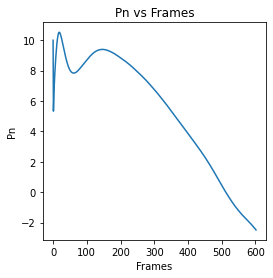

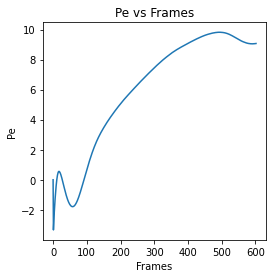

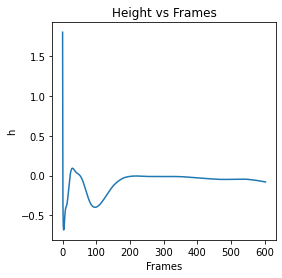

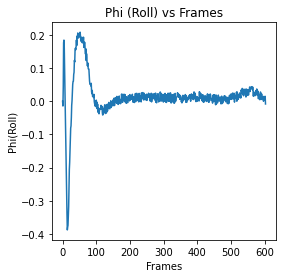

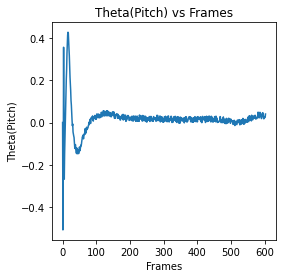

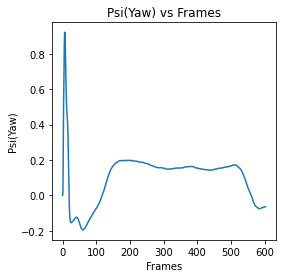

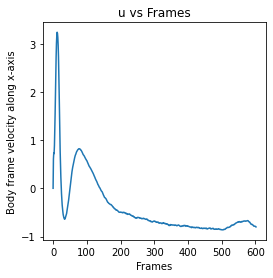

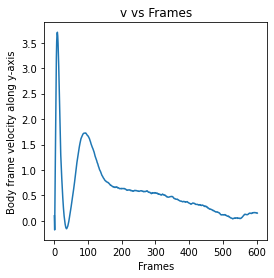

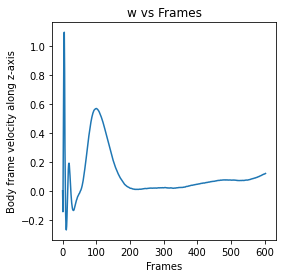

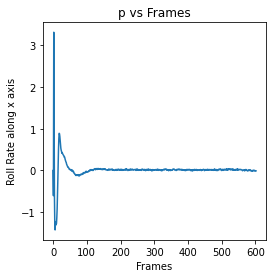

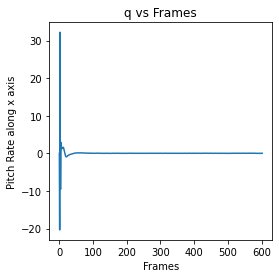

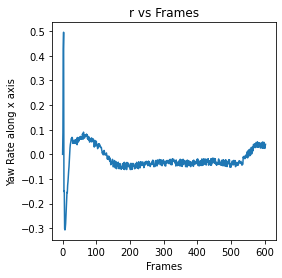

In [47]:
fig1 = plt.figure(figsize=(4,4))
ax1 = fig1.add_subplot()
ax1.set_xlabel('Frames')
ax1.set_ylabel('Pn')
ax1.set_title('Pn vs Frames')
Plot=ax1.plot(pn_data)
Plot=ax1.plot(pn_c_data)

fig2 = plt.figure(figsize=(4,4))
ax2 = fig2.add_subplot()
ax2.set_xlabel('Frames')
ax2.set_ylabel('Pe')
ax2.set_title('Pe vs Frames')
Plot=ax2.plot(pe_data)
Plot=ax2.plot(pe_c_data)

fig3 = plt.figure(figsize=(4,4))
ax3 = fig3.add_subplot()
ax3.set_xlabel('Frames')
ax3.set_ylabel('h')
ax3.set_title('Height vs Frames')
Plot=ax3.plot(pd_data)
Plot=ax3.plot(pd_c_data)

fig4 = plt.figure(figsize=(4,4))
ax4 = fig4.add_subplot()
ax4.set_xlabel('Frames')
ax4.set_ylabel('Phi(Roll)')
ax4.set_title('Phi (Roll) vs Frames')
Plot=ax4.plot(phi_data)
Plot=ax4.plot(phi_c_data)

fig5 = plt.figure(figsize=(4,4))
ax5 = fig5.add_subplot()
ax5.set_xlabel('Frames')
ax5.set_ylabel('Theta(Pitch)')
ax5.set_title('Theta(Pitch) vs Frames')
Plot=ax5.plot(theta_data)
Plot=ax5.plot(theta_c_data)

fig6 = plt.figure(figsize=(4,4))
ax6 = fig6.add_subplot()
ax6.set_xlabel('Frames')
ax6.set_ylabel('Psi(Yaw)')
ax6.set_title('Psi(Yaw) vs Frames')
Plot=ax6.plot(psi_data)
Plot=ax6.plot(psi_c_data)

fig7 = plt.figure(figsize=(4,4))
ax7 = fig7.add_subplot()
ax7.set_xlabel('Frames')
ax7.set_ylabel('Body frame velocity along x-axis')
ax7.set_title('u vs Frames')
Plot=ax7.plot(u_data)
Plot=ax7.plot(u_c_data)

fig8 = plt.figure(figsize=(4,4))
ax8 = fig8.add_subplot()
ax8.set_xlabel('Frames')
ax8.set_ylabel('Body frame velocity along y-axis')
ax8.set_title('v vs Frames')
Plot=ax8.plot(v_data)
Plot=ax8.plot(v_c_data)

fig9 = plt.figure(figsize=(4,4))
ax9 = fig9.add_subplot()
ax9.set_xlabel('Frames')
ax9.set_ylabel('Body frame velocity along z-axis')
ax9.set_title('w vs Frames')
Plot=ax9.plot(w_data)
Plot=ax9.plot(w_c_data)

fig10 = plt.figure(figsize=(4,4))
ax10 = fig10.add_subplot()
ax10.set_xlabel('Frames')
ax10.set_ylabel('Roll Rate along x axis')
ax10.set_title('p vs Frames')
Plot=ax10.plot(p_data)

fig11 = plt.figure(figsize=(4,4))
ax11 = fig11.add_subplot()
ax11.set_xlabel('Frames')
ax11.set_ylabel('Pitch Rate along x axis')
ax11.set_title('q vs Frames')
Plot=ax11.plot(q_data)

fig12 = plt.figure(figsize=(4,4))
ax12 = fig12.add_subplot()
ax12.set_xlabel('Frames')
ax12.set_ylabel('Yaw Rate along x axis')
ax12.set_title('r vs Frames')
Plot=ax12.plot(r_data)
Plot=ax12.plot(r_c_data)

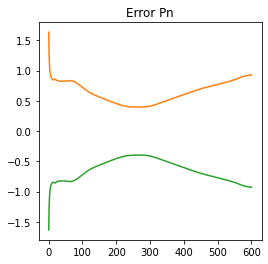

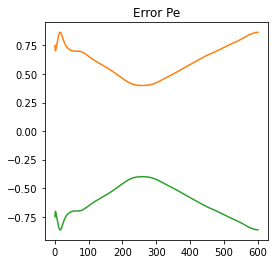

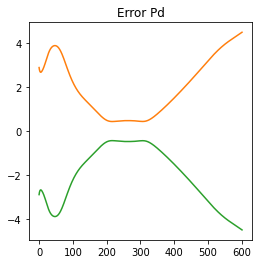

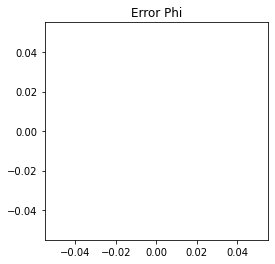

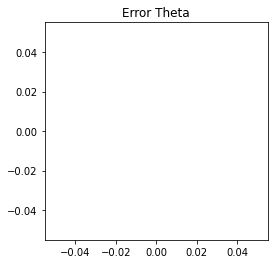

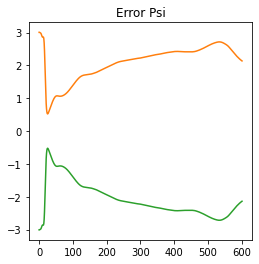

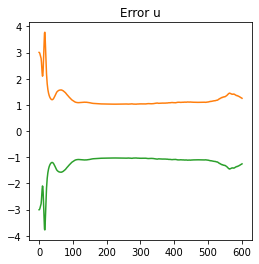

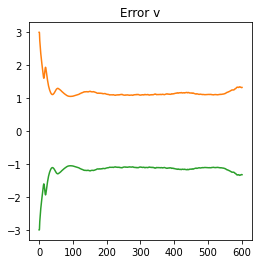

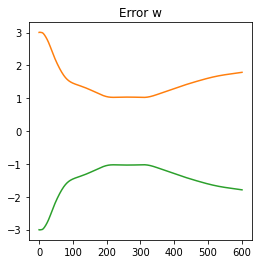

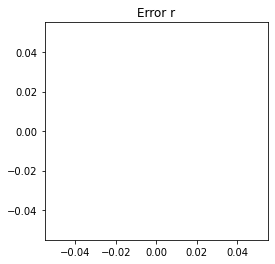

In [48]:
fig13 = plt.figure(figsize=(4,4))
ax13 = fig13.add_subplot()
ax13.set_title('Error Pn')
Plot=ax13.plot(error_pn)
Plot=ax13.plot(Pekf_pn_data)
Plot=ax13.plot(NPekf_pn_data)


fig14 = plt.figure(figsize=(4,4))
ax14 = fig14.add_subplot()
ax14.set_title('Error Pe')
Plot=ax14.plot(error_pe)
Plot=ax14.plot(Pekf_pe_data)
Plot=ax14.plot(NPekf_pe_data)

fig15 = plt.figure(figsize=(4,4))
ax15 = fig15.add_subplot()
ax15.set_title('Error Pd')
Plot=ax15.plot(error_pd)
Plot=ax15.plot(Pekf_pd_data)
Plot=ax15.plot(NPekf_pd_data)

fig16 = plt.figure(figsize=(4,4))
ax16 = fig16.add_subplot()
ax16.set_title('Error Phi')
Plot=ax16.plot(error_phi)

fig17 = plt.figure(figsize=(4,4))
ax17 = fig17.add_subplot()
ax17.set_title('Error Theta')
Plot=ax17.plot(error_theta)

fig18 = plt.figure(figsize=(4,4))
ax18 = fig18.add_subplot()
ax18.set_title('Error Psi')
Plot=ax18.plot(error_psi)
Plot=ax18.plot(Pekf_psi_data)
Plot=ax18.plot(NPekf_psi_data)

fig19 = plt.figure(figsize=(4,4))
ax19 = fig19.add_subplot()
ax19.set_title('Error u')
Plot=ax19.plot(error_u)
Plot=ax19.plot(Pekf_u_data)
Plot=ax19.plot(NPekf_u_data)

fig20 = plt.figure(figsize=(4,4))
ax20 = fig20.add_subplot()
ax20.set_title('Error v')
Plot=ax20.plot(error_v)
Plot=ax20.plot(Pekf_v_data)
Plot=ax20.plot(NPekf_v_data)

fig21 = plt.figure(figsize=(4,4))
ax21 = fig21.add_subplot()
ax21.set_title('Error w')
Plot=ax21.plot(error_w)
Plot=ax21.plot(Pekf_w_data)
Plot=ax21.plot(NPekf_w_data)

fig22 = plt.figure(figsize=(4,4))
ax22 = fig22.add_subplot()
ax22.set_title('Error r')
Plot=ax22.plot(error_r)